### Definitions:
- "Runner" is the name of the person who placed the bet.
- "ExpROI" is the model's expected return on investment. 
- "Stake" is the amount the runner successfully placed on the selection.
- "PriceTaken" is the odds that the runner placed, in decimal format. 
- "EW" is a binary indicator of whether the bet was an Each Way bet. 
- "Terms" is the denominator in the EW price. e.g.) Terms = 3 implies a 1/3 EW bet.
- "Deduction" is the "Rule 4" deduction for the horse. e.g.) Deduction = 0.1 implies a 10p deduction.
- "BSP" is the Betfair Starting Price, the odds found on Betfair Exchange for the horse to win at the race start time.
- "BSPplace" is the Betfair Starting Price for the horse to place, found at the race start time.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [5]:
#import data from csv file
runner_bets_df = pd.read_csv('runner_bets.csv')
runner_bets_df

,Date,Runner,RaceID,Horse,ExpROI,Stake,PriceTaken,EW,Places,Terms,Winner,Placed,Deduction,BSP,BSPplace,Time_Placed
0,2021-04-01,RichardW,Ffos Las 17:42,This Breac,0.158000,40.0,26.0,0,1,0,0.0,0.0,0.0,17.000000,4.550097,09:56
1,2021-04-01,RichardW,Ffos Las 17:10,Timassini,0.117250,50.0,21.0,0,1,0,0.0,0.0,0.0,23.000000,5.657376,09:56
2,2021-04-01,RichardW,Ffos Las 17:42,Do It For Thy Sen,0.046130,200.0,6.0,0,1,0,0.0,0.0,0.0,4.925280,2.107342,09:56
3,2021-04-01,StepR,Ffos Las 17:10,Saddlers Quest,0.055380,30.0,19.0,0,1,0,0.0,0.0,0.0,11.503926,4.054723,08:59
4,2021-04-01,PaulR,Ffos Las 17:10,Saddlers Quest,0.055380,50.0,19.0,0,1,0,0.0,0.0,0.0,11.503926,4.054723,10:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82132,2021-11-16,Jimmy,Ayr 14:15,Ask Blossomfort,0.021531,200.0,8.5,0,1,0,1.0,1.0,0.0,11.500000,3.550783,13:31
82133,2021-11-16,PaulS,Ayr 14:15,Ask Blossomfort,0.021531,100.0,9.0,0,1,0,1.0,1.0,0.0,11.500000,3.550783,13:34
82134,2021-11-16,PaulS,Ayr 14:50,Upandatit,0.064159,75.0,15.0,0,1,0,0.0,1.0,0.0,12.184800,3.042881,14:02
82135,2021-11-16,Tassos,Ayr 15:53,Paddock Cottage,0.052600,600.0,4.5,0,1,0,0.0,1.0,0.0,5.800000,1.940000,15:28


## Q1:
Assume that BSP and BSPplace are prices representing the true probability for a horse to win and place, respectively.

- a). Plot the cumulative PnL and EV as a function of time in days.

- b). Plot a 2-week rolling PnL and EV average.

- c). Do you think that your assumed EV is an accurate representation of your real edge? (Hint: Run a Monte Carlo simulation).

#### General Equation for PnL and EV in Case where there is EW betting and deductions: 

I was honestly very confused with how to calculate the PnL and EV since I'm not literate in the dynamics of EW bettin but I developed these equations for the PnL and EV based on my understanding of how they work. I assumed that if an EW bet is placed, the stake is twice of what it actually says (from what I read online). Also, I wasn't sure if the deduction is always placed on a bet or only if the horse withdraws from the race, but since I didn't see a variable for this I assumed that it's always done, spceifically to the bet on a horse placing first. In this manner, the PnL is equal to the stake of the runner times the decimal odds of placing first (minus the deduction) IF the horse wins, plus the decimal odds of the horse placing IF the bet is an EW bet AND it the horse places divided by the terms, minus the stake (or two times the stake if it is an EW bet as per the previous assumption). This can be summarised through the following equation which follows vectorised operations of the pandas DataFrame to calculate the PnL. 

$$
\text{PnL} = s * ((b - d) * w + \frac{1}{T + (1 - e)} * b_p * p * e - (1 + e))
$$

For the EV of a bet, I used the equation that EV is equal to the probability of winning times the amount won if thats the case minus the probability of losing times the amount lost if thats the case. Since there are two components to winning, the first part of this equation is the sum of the probability of the horse winning the race ($\frac{1}{\text{BSP}}$) times the amount won if that happens ($(\text{BSP} - \text{deduction}) * \text{stake}$) and the probability of winning the EW bet (i.e. $\frac{1}{\text{BSPplace}}$) times the amount won if that happens ($(\frac{1}{T + (1 - e)}\text{BSPplace}) * \text{stake}$) IF the bet is an EW bet (therefore need to multiply by the boolean that specifies that). The second part is the probability of losing minus the amount lost if that happens. This can be described by the following equation. 

$$
EV = p_W * s\left(b - d\right) + p_{W_\text{place}} * \frac{1}{T + (1 - e)} * b_p * e - s * (1 - p_W + e * (1 - p_{W_{\text{place}}}))
$$

where 

- $b$ = BSP
- $b_p$ = BSPplace
- $w$ = winner
- $d$ = deduction
- $s$ = stake
- $T$ = Terms
- $e$ = EW
- $p$ = placed
- $p_W = \frac{1}{b}$ is the probability of winning the race
- $p_{W_{\text{place}}} = \frac{1}{b_p}$ is the probability of placing

In [6]:
b = runner_bets_df['BSP']
s = runner_bets_df['Stake']
e = runner_bets_df['EW']
w = runner_bets_df['Winner']
p = runner_bets_df['Placed']
T = runner_bets_df['Terms']
d = runner_bets_df['Deduction']
b_p = runner_bets_df['BSPplace']
p_w = 1 / b 
p_wplace = 1 / b_p

#calculate PnL and EV
runner_bets_df['PnL'] = s * ((b - d)*w + (1 / (T + 1 - e)) * b_p * p * e - (1 + e))
runner_bets_df['EV'] = p_w * s * (b - d) + p_wplace * (1 / (T + 1 - e)) * b_p * e - s * (1 - p_w + e * (1 - p_wplace))

In [7]:
runner_bets_df

,Date,Runner,RaceID,Horse,ExpROI,Stake,PriceTaken,EW,Places,Terms,Winner,Placed,Deduction,BSP,BSPplace,Time_Placed,PnL,EV
0,2021-04-01,RichardW,Ffos Las 17:42,This Breac,0.158000,40.0,26.0,0,1,0,0.0,0.0,0.0,17.000000,4.550097,09:56,-40.0,2.352941
1,2021-04-01,RichardW,Ffos Las 17:10,Timassini,0.117250,50.0,21.0,0,1,0,0.0,0.0,0.0,23.000000,5.657376,09:56,-50.0,2.173913
2,2021-04-01,RichardW,Ffos Las 17:42,Do It For Thy Sen,0.046130,200.0,6.0,0,1,0,0.0,0.0,0.0,4.925280,2.107342,09:56,-200.0,40.606832
3,2021-04-01,StepR,Ffos Las 17:10,Saddlers Quest,0.055380,30.0,19.0,0,1,0,0.0,0.0,0.0,11.503926,4.054723,08:59,-30.0,2.607805
4,2021-04-01,PaulR,Ffos Las 17:10,Saddlers Quest,0.055380,50.0,19.0,0,1,0,0.0,0.0,0.0,11.503926,4.054723,10:01,-50.0,4.346342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82132,2021-11-16,Jimmy,Ayr 14:15,Ask Blossomfort,0.021531,200.0,8.5,0,1,0,1.0,1.0,0.0,11.500000,3.550783,13:31,2100.0,17.391304
82133,2021-11-16,PaulS,Ayr 14:15,Ask Blossomfort,0.021531,100.0,9.0,0,1,0,1.0,1.0,0.0,11.500000,3.550783,13:34,1050.0,8.695652
82134,2021-11-16,PaulS,Ayr 14:50,Upandatit,0.064159,75.0,15.0,0,1,0,0.0,1.0,0.0,12.184800,3.042881,14:02,-75.0,6.155210
82135,2021-11-16,Tassos,Ayr 15:53,Paddock Cottage,0.052600,600.0,4.5,0,1,0,0.0,1.0,0.0,5.800000,1.940000,15:28,-600.0,103.448272


In [20]:
#convert dates to day number and add column
import datetime
dates_list = [datetime.datetime.strptime(date + '-' + time, '%Y-%m-%d-%H:%M') for date, time in zip(runner_bets_df['Date'], runner_bets_df['Time_Placed'])]
d0 = dates_list[0]
days = [(date - d0).days + ((date - d0).seconds % (3600*24)) / (3600*24) for date in dates_list]
runner_bets_df['Day'] = days

#make column for cumulative PnL and EV
runner_bets_df['Cumulative PnL'] = np.cumsum(runner_bets_df['PnL'])
runner_bets_df['Cumulative EV'] = np.cumsum(runner_bets_df['EV'])
runner_bets_df

,Date,Runner,RaceID,Horse,ExpROI,Stake,PriceTaken,EW,Places,Terms,...,Placed,Deduction,BSP,BSPplace,Time_Placed,PnL,EV,Day,Cumulative PnL,Cumulative EV
0,2021-04-01,RichardW,Ffos Las 17:42,This Breac,0.158000,40.0,26.0,0,1,0,...,0.0,0.0,17.000000,4.550097,09:56,-40.0,2.352941,0.000000,-40.0,2.352941
1,2021-04-01,RichardW,Ffos Las 17:10,Timassini,0.117250,50.0,21.0,0,1,0,...,0.0,0.0,23.000000,5.657376,09:56,-50.0,2.173913,0.000000,-90.0,4.526854
2,2021-04-01,RichardW,Ffos Las 17:42,Do It For Thy Sen,0.046130,200.0,6.0,0,1,0,...,0.0,0.0,4.925280,2.107342,09:56,-200.0,40.606832,0.000000,-290.0,45.133686
3,2021-04-01,StepR,Ffos Las 17:10,Saddlers Quest,0.055380,30.0,19.0,0,1,0,...,0.0,0.0,11.503926,4.054723,08:59,-30.0,2.607805,-0.039583,-320.0,47.741491
4,2021-04-01,PaulR,Ffos Las 17:10,Saddlers Quest,0.055380,50.0,19.0,0,1,0,...,0.0,0.0,11.503926,4.054723,10:01,-50.0,4.346342,0.003472,-370.0,52.087833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82132,2021-11-16,Jimmy,Ayr 14:15,Ask Blossomfort,0.021531,200.0,8.5,0,1,0,...,1.0,0.0,11.500000,3.550783,13:31,2100.0,17.391304,229.149306,inf,inf
82133,2021-11-16,PaulS,Ayr 14:15,Ask Blossomfort,0.021531,100.0,9.0,0,1,0,...,1.0,0.0,11.500000,3.550783,13:34,1050.0,8.695652,229.151389,inf,inf
82134,2021-11-16,PaulS,Ayr 14:50,Upandatit,0.064159,75.0,15.0,0,1,0,...,1.0,0.0,12.184800,3.042881,14:02,-75.0,6.155210,229.170833,inf,inf
82135,2021-11-16,Tassos,Ayr 15:53,Paddock Cottage,0.052600,600.0,4.5,0,1,0,...,1.0,0.0,5.800000,1.940000,15:28,-600.0,103.448272,229.230556,inf,inf


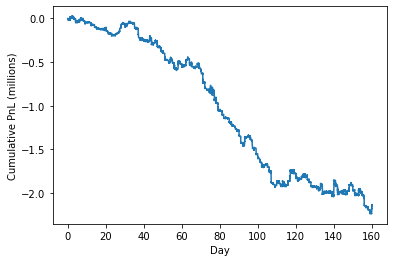

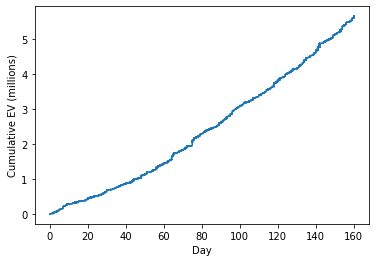

In [21]:
plt.figure()
plt.plot(runner_bets_df['Day'], runner_bets_df['Cumulative PnL'] / 1e6, label='Cumulative PnL')
plt.xlabel('Day')
plt.ylabel('Cumulative PnL (millions)')

plt.figure()
plt.plot(runner_bets_df['Day'], runner_bets_df['Cumulative EV'] / 1e6, label='Cumulative EV')
plt.xlabel('Day')
plt.ylabel('Cumulative EV (millions)');

[nan nan nan ... nan nan nan]


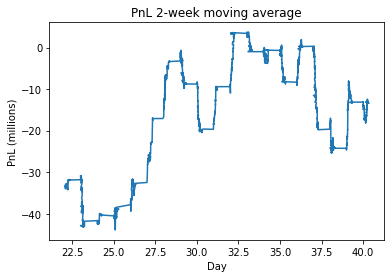

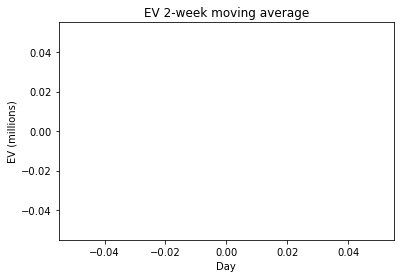

In [38]:
PnL = runner_bets_df['PnL'].copy().to_numpy()
EV = runner_bets_df['EV'].copy().to_numpy()


cum_PnL = np.cumsum(np.insert(PnL,0,0))
cum_EV = np.cumsum(np.insert(EV,0,0))
window_size = int(14 * len(cum_PnL) / np.max(runner_bets_df['Day'])) #get windowsize of every 2 weeks
PnL_moving_avg = (cum_PnL[window_size:] - cum_PnL[:-window_size]) / window_size
EV_moving_avg = (cum_EV[window_size:] - cum_EV[:-window_size]) / window_size

days = runner_bets_df['Day'].copy().to_numpy()[window_size-1:]
plt.figure()
plt.plot(days, PnL_moving_avg)
plt.title('PnL 2-week moving average')
plt.xlabel('Day')
plt.ylabel('PnL (millions)')

print(EV_moving_avg)
plt.figure()
plt.plot(days, EV_moving_avg)
plt.title('EV 2-week moving average')
plt.xlabel('Day')
plt.ylabel('EV (millions)');

##### I couldn't keep going to Q2 and Q3 due to time constraints and because I fear I calculated the PnL and the EV wrongly :/ 